# Initialization

**DEFINE EVERYTHING**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile

def generate_unique_geometric_sequence(max_num, base=1.15):
    sequence = []
    i = 1

    while i <= max_num:
        sequence.append(int(round(i)))
        i *= base  # Multiply by base to increase the step size progressively

    # Ensure the sequence includes the max_num if it wasn't included
    if sequence[-1] != max_num:
        sequence.append(max_num)

    # Remove duplicates and return unique sequence
    unique_sequence = np.unique(sequence).tolist()

    return unique_sequence

# Function to compute k-th power of matrix A efficiently
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A, k times
        print('Computing...')
    return result

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5):
    print('Structural path analysis...')
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    print('Calculate direct influence')
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    print('Calculate higher-order paths')
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        print(f'Computing order {k} paths')
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        print(f'Order {k} paths computed')
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration


    return paths

# Define the analysis function
def perform_analysis(year):
    print(f'Performing analysis for the year {year}')
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    print('Filter Emissions data')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    FD_vector = FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Perform structural path analysis using Taylor series method
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    print('Flatten paths')
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create combined country-sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Filter for selected countries
    selected_countries = ('BGD', 'KOR', 'BRA')
    selected_indices = [i for i, label in enumerate(country_sector_labels) if label.split('_')[0] in selected_countries]

    # Filter paths_df_taylor for selected countries
    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Path_Index'].isin(selected_indices)]

    # Filter sector labels and country labels for selected countries
    sector_labels_selected = sector_labels[selected_indices]
    country_labels_selected = country_labels[selected_indices]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    # Create directed graph from the input-output matrix A
    print('Create directed graph')
def create_network(A, labels, country_labels):
    G = nx.DiGraph()
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] != 0:
                G.add_edge(f"{country_labels[i]}_{labels[i]}", f"{country_labels[j]}_{labels[j]}", weight=A[i, j])
    return G


    def find_alpha_beta(G):
        print('Find alpha and beta')
        # Get the adjacency matrix of the graph
        A = nx.to_numpy_array(G)
        # Calculate the largest eigenvalue
        largest_eigenvalue = max(np.linalg.eigvals(A))
        # Define alpha as a fraction of the reciprocal of the largest eigenvalue
        alpha = 0.1 * (1 / largest_eigenvalue)
        # Set beta to 1.0 (standard value)
        beta = 1.0
        return alpha, beta

    # Compute centrality measures
    def compute_centralities(G):
        print('Compute centrality measures')
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)  # For directed graphs
        out_degree_centrality = nx.out_degree_centrality(G)  # For directed graphs
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    # Create directed graph
    G = create_network(A, sector_labels)
    centrality = compute_centralities(G)

    # Prepare DataFrame with results for selected countries only
    df = pd.DataFrame({
        'Sector': sector_labels_selected,
        'Country': country_labels_selected,
        'Year': year,
        'Total Impact': total_impact[selected_indices],
        'Eigenvector Centrality': [centrality['eigenvector'][sector] for sector in sector_labels_selected],
        'Bonacich Centrality': [centrality['bonacich'][sector] for sector in sector_labels_selected],
        'Degree Centrality': [centrality['degree'][sector] for sector in sector_labels_selected],
        'Betweenness Centrality': [centrality['betweenness'][sector] for sector in sector_labels_selected],
        'In-Degree Centrality': [centrality['in_degree'][sector] for sector in sector_labels_selected],
        'Out-Degree Centrality': [centrality['out_degree'][sector] for sector in sector_labels_selected],
        'Country_Sector': [f"{country}_{sector}" for country, sector in zip(country_labels_selected, sector_labels_selected)]
    })


    # Filter paths_df_taylor for selected countries
    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Path_Index'].isin(selected_indices)]
    paths_taylor_selected = [path for path in paths_taylor if path['order'] in [1, 2, 3]]

    # Flatten all paths for inclusion in the DataFrame
    for path in paths_taylor_selected:
        order = path['order']
        df[f'Order_{order}_Paths'] = np.nan  # Initialize column for paths
        path_indices = paths_df_taylor_selected[paths_df_taylor_selected['Order'] == order]['Path_Index'].values
        impacts = paths_df_taylor_selected[paths_df_taylor_selected['Order'] == order]['Impact'].values
        for i, idx in enumerate(path_indices):
            df.loc[idx, f'Order_{order}_Paths'] = impacts[i]

    # Save all relevant variables for this year, including the databases
    print('Save all relevant variables')
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 3]['Impact'].values,
        'total_impact': total_impact[selected_indices],
        'G': G,
        'centrality': centrality,
        'paths_taylor': paths_taylor,  # Save all Taylor paths along with their orders
        'paths_df_taylor': paths_df_taylor,  # Save the flattened DataFrame for convenience
        'sector_labels': sector_labels_selected,
        'country_labels': country_labels_selected,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact[selected_indices],
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)
        print(f'Variables saved to {save_path}')

    return df

# Example usage:
years = range(1990, 2016)
results = pd.DataFrame()

for year in years:
    print(f"\nAnalysis for the year {year}:\n")
    year_df = perform_analysis(year)
    results = pd.concat([results, year_df])
    print(f'\nAnalysis for {year} saved in the drive')

# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/Yannis/selected_countries_1990-2015_results_analysis.csv', index=False)
print('All results saved')

# Display the DataFrame
results.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Analysis for the year 1990:

Performing analysis for the year 1990
Filter Emissions data
Structural path analysis...
Calculate direct influence
Calculate higher-order paths
Computing order 2 paths
Order 2 paths computed
Computing order 3 paths
Order 3 paths computed
Computing order 4 paths
Order 4 paths computed
Computing order 5 paths
Order 5 paths computed
Computing order 6 paths
Order 6 paths computed
Computing order 7 paths
Order 7 paths computed
Computing order 8 paths
Order 8 paths computed
Computing order 9 paths
Order 9 paths computed
Computing order 10 paths
Order 10 paths computed
Computing order 11 paths
Order 11 paths computed
Computing order 12 paths
Order 12 paths computed
Computing order 13 paths
Order 13 paths computed
Computing order 14 paths
Order 14 paths computed
Computing order 15 paths
Order 15 paths computed
Flatten paths
Create direct

KeyError: "There is no item named 'labels_VA.txt' in the archive"

This code takes 2 minutes a year with only 3 max order paths. Let's get like 15 to see how long it takes.

# Visualizing

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile
from scipy.linalg import inv
from scipy.sparse.linalg import eigs
import concurrent.futures

# Load saved variables function
def load_saved_variables(year):
    print(f'Loading variables for the year {year}')
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)
    print(f'Variables loaded from {save_path}')
    return variables

Mounted at /content/drive


**Networks**

---



Debugging functions just in case

In [2]:
#Debugging functions just in case

def check_raw_data_for_country(year, country):
    variables = load_saved_variables(year)

    # Extract sector and country labels
    sector_labels = variables['sector_labels']
    country_labels = variables['country_labels']
    country_sector_labels = variables['country_sector_labels']

    # Filter for the selected country
    filtered_labels = [label for label in country_sector_labels if label.startswith(country)]

    print(f"Found {len(filtered_labels)} entries for {country} in {year}.")
    print("Sample entries:", filtered_labels[:5])

# Example usage
check_raw_data_for_country(2000, 'BRA')

def check_connections(year, sector):
    variables = load_saved_variables(year)
    G = variables['G']
    connections = list(G.edges(sector))
    print(f"Connections for {sector} in {year}: {connections}")

# Example usage
check_connections(2000, 'Agriculture')

def inspect_adjacency_matrix(year, sector):
    variables = load_saved_variables(year)
    sector_labels = variables['sector_labels']
    A = variables['A']

    # Find the index of the sector
    sector_index = np.where(sector_labels == sector)[0][0]

    # Print the row and column corresponding to the sector
    print(f"Adjacency matrix row for {sector}: {A[sector_index, :]}")
    print(f"Adjacency matrix column for {sector}: {A[:, sector_index]}")

# Example usage
inspect_adjacency_matrix(2000, 'Agriculture')


Loading variables for the year 2000
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_2000_selected_countries.pkl
Found 26 entries for BRA in 2000.
Sample entries: ['BRA_Agriculture', 'BRA_Fishing', 'BRA_Mining and Quarrying', 'BRA_Food & Beverages', 'BRA_Textiles and Wearing Apparel']
Loading variables for the year 2000
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_2000_selected_countries.pkl
Connections for Agriculture in 2000: [('Agriculture', 'Agriculture'), ('Agriculture', 'Fishing'), ('Agriculture', 'Mining and Quarrying'), ('Agriculture', 'Food & Beverages'), ('Agriculture', 'Textiles and Wearing Apparel'), ('Agriculture', 'Wood and Paper'), ('Agriculture', 'Petroleum, Chemical and Non-Metallic Mineral Products'), ('Agriculture', 'Metal Products'), ('Agriculture', 'Electrical and Machinery'), ('Agriculture', 'Transport Equipment'), ('Agriculture', 'Other Manufacturing'), ('Agriculture', 'Recycling'), ('Agriculture', 'Electricity, Gas and Water

Loading variables for the year 2000
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_2000_selected_countries.pkl
Full weighted network for 2000 contains 27 nodes and 728 edges.


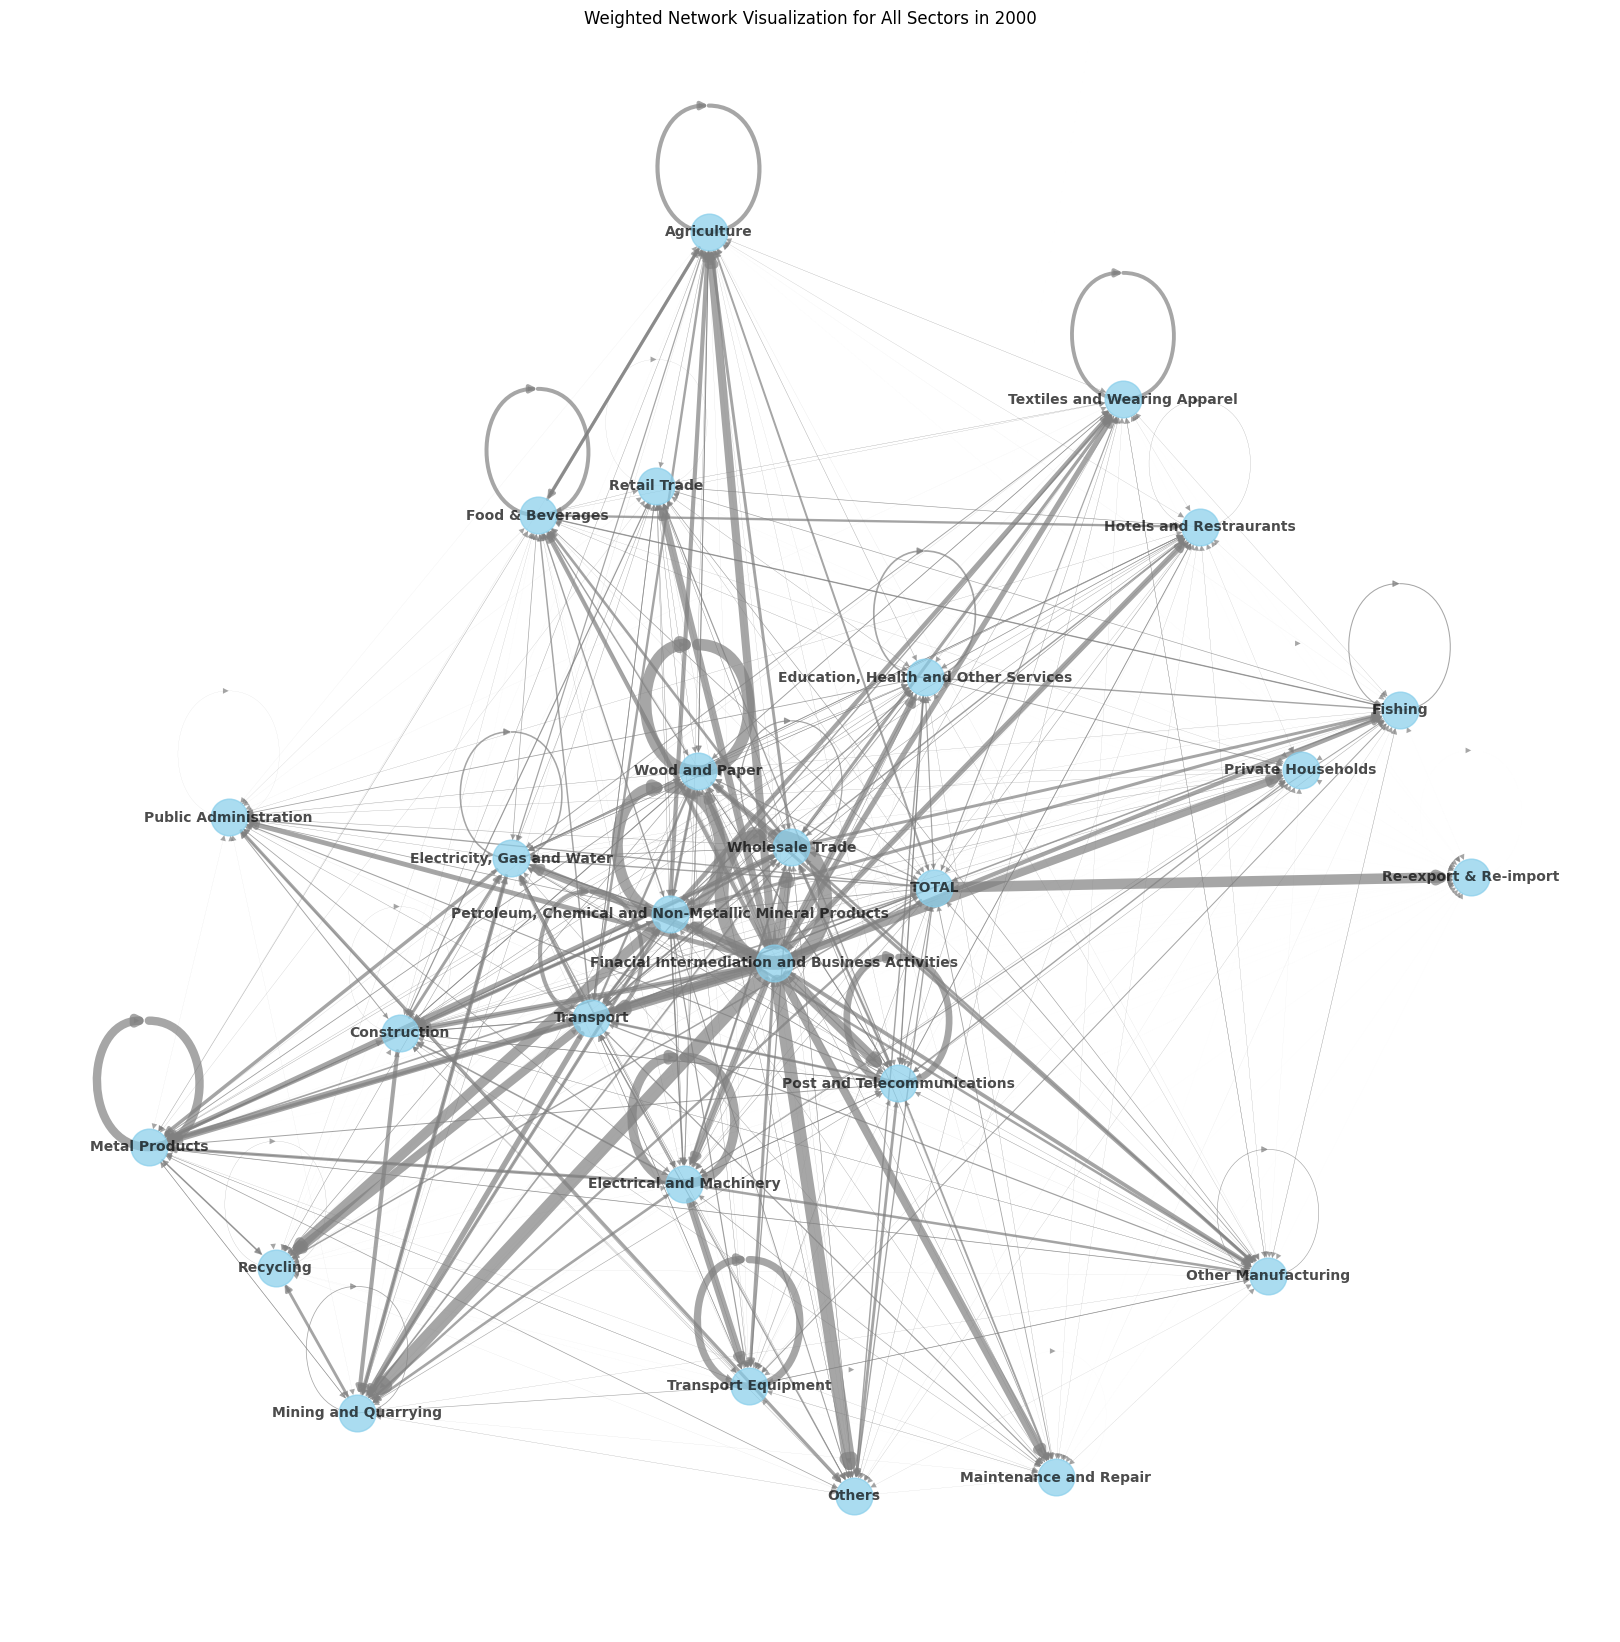

In [ ]:
def visualize_weighted_network(year):
    # Load the saved variables for the given year
    variables = load_saved_variables(year)

    # Extract the full graph
    G = variables['G']

    print(f"Full weighted network for {year} contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        print(f"No data available for the year {year}.")
        return

    # Extract edge weights
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]

    # Normalize edge weights for better visualization (optional)
    max_weight = max(edge_weights)
    normalized_weights = [weight / max_weight * 10 for weight in edge_weights]

    # Draw the weighted network
    plt.figure(figsize=(16, 16))
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Adjust layout parameters as needed
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray',
            font_size=10, font_weight='bold', width=normalized_weights, alpha=0.7)
    plt.title(f'Weighted Network Visualization for All Sectors in {year}')
    plt.show()

# Example usage
visualize_weighted_network(2000)


**Transform into a GIF**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import imageio

# Load variables and correctly handle the "TOTAL" node by excluding it from the graph
def load_and_prepare_network(year):
    variables = load_saved_variables(year)

    G = variables.get('G')

    # Optionally, rename the "TOTAL" node to "Others in ROW" if you intend to keep it in the graph
    if "Others in ROW" in G:
        mapping = {"Others in ROW": "ROW_Total"}
        G = nx.relabel_nodes(G, mapping)
        print(f"Renamed 'Others in ROW' to 'ROW_Total' for {year}.")

    return G, variables

# Visualize the network and optionally save it with custom options
def visualize_and_save_network(G, year, save_path=None, node_color='skyblue', edge_color='gray',
                               node_size=700, font_size=10, alpha=0.7, k_layout=0.5):
    plt.figure(figsize=(16, 16))
    pos = nx.spring_layout(G, k=k_layout, seed=42)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    max_weight = max(edge_weights)
    normalized_weights = [weight / max_weight * 10 for weight in edge_weights]

    nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color, edge_color=edge_color,
            font_size=font_size, font_weight='bold', width=normalized_weights, alpha=alpha)

    # Add the year as a text annotation on the graph
    plt.text(0.05, 0.95, f'{year}', horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=24, fontweight='bold')

    plt.title(f'Weighted Network Visualization for All Sectors in {year}')

    if save_path:
        plt.savefig(save_path)
        plt.close()  # Close the figure to avoid displaying it during processing
    else:
        plt.show()

# Process all years: exclude "TOTAL", visualize, and save images with customization options
def process_and_save_networks(start_year, end_year, folder_path, node_color='skyblue', edge_color='gray',
                              node_size=700, font_size=10, alpha=0.7, k_layout=0.5):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for year in range(start_year, end_year + 1):
        print(f"Processing networks for year {year}...")
        G, variables = load_and_prepare_network(year)

        if G.number_of_nodes() > 0 and G.number_of_edges() > 0:
            image_path = os.path.join(folder_path, f'network_{year}.png')
            visualize_and_save_network(G, year, save_path=image_path, node_color=node_color, edge_color=edge_color,
                                       node_size=node_size, font_size=font_size, alpha=alpha, k_layout=k_layout)

            # Overwrite the original file with the updated variables
            save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
            with open(save_path, 'wb') as file:
                pickle.dump(variables, file)
                print(f'Modified variables for {year} saved to {save_path}')
        else:
            print(f"No data available for the year {year}.")

# Create GIF from saved images
def create_gif_from_images(folder_path, output_gif_path, duration=0.5):
    image_files = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')])
    images = [imageio.imread(filename) for filename in image_files]
    imageio.mimsave(output_gif_path, images, duration=duration)

# Example usage with customization options
folder_path = '/content/drive/MyDrive/Yannis/Images'
process_and_save_networks(1990, 2016, folder_path,
                          node_color='lightblue', edge_color='black',
                          node_size=800, font_size=12, alpha=0.8, k_layout=0.6)
create_gif_from_images(folder_path, '/content/drive/MyDrive/Yannis/Images/Sectors_Networks_GIF.gif', duration=1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing networks for year 1990...


NameError: name 'load_saved_variables' is not defined

**Visualize for Countries**

---



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data for the year 2015
Filter Emissions data


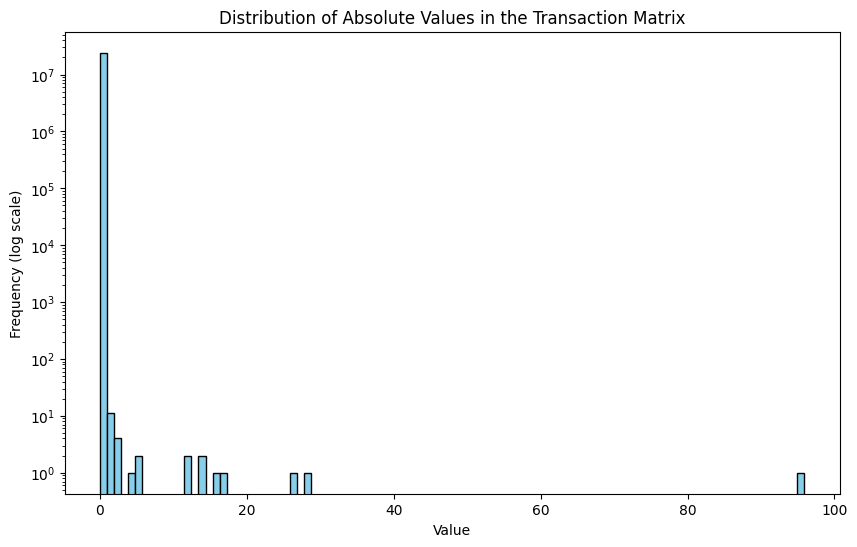

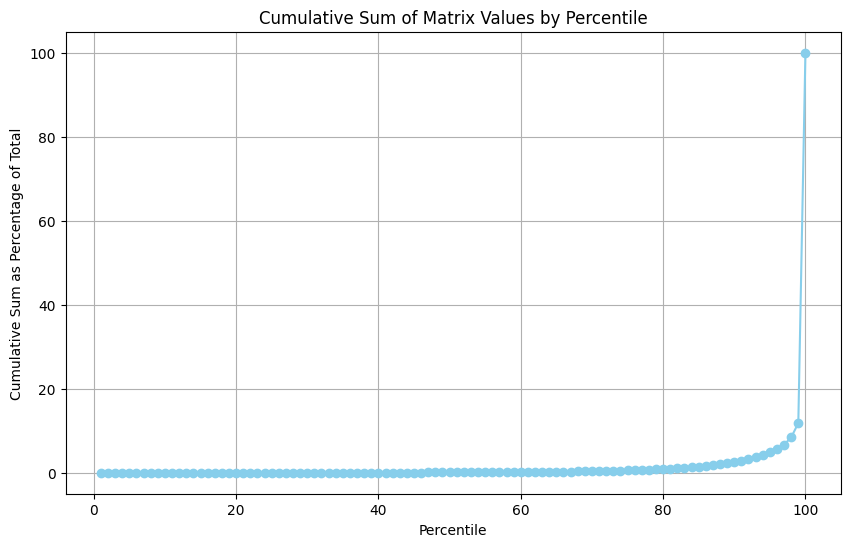

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

def load_variables(year):
    print(f'Loading data for the year {year}')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    print('Filter Emissions data')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    FD_vector = Eora_pp_FD.sum(axis=1)
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)

    A = Eora_pp_T_matrix / xout
    f_matrix = Eora_pp_Q_emissions_matrix / xout
    f = f_matrix.sum(axis=0)

    return A, f, labels_T

def plot_value_distribution(A):
    # Flatten the matrix and take the absolute values
    flat_A = np.abs(A.flatten())

    # Plot histogram of the values
    plt.figure(figsize=(10, 6))
    plt.hist(flat_A, bins=100, log=True, color='skyblue', edgecolor='black')
    plt.title('Distribution of Absolute Values in the Transaction Matrix')
    plt.xlabel('Value')
    plt.ylabel('Frequency (log scale)')
    plt.show()

    return flat_A

def define_threshold(flat_A, percentile=90):
    threshold = np.percentile(flat_A, percentile)
    print(f'Threshold set at the {percentile}th percentile: {threshold}')
    return threshold

import numpy as np
import matplotlib.pyplot as plt

def cumulative_sum_by_percentile(flat_A):
    # Sort the flattened matrix
    sorted_A = np.sort(flat_A)

    # Calculate the cumulative sum
    cumulative_sum = np.cumsum(sorted_A)

    # Normalize by the total sum to get the percentage of total sum
    total_sum = cumulative_sum[-1]
    cumulative_sum_percent = cumulative_sum / total_sum * 100

    # Generate percentiles (1st to 100th)
    percentiles = np.arange(1, 101)

    # Calculate the cumulative sum at each percentile
    cumulative_sum_at_percentiles = np.percentile(cumulative_sum_percent, percentiles)

    # Plot the cumulative sum against percentiles
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, cumulative_sum_at_percentiles, color='skyblue', marker='o')
    plt.title('Cumulative Sum of Matrix Values by Percentile')
    plt.xlabel('Percentile')
    plt.ylabel('Cumulative Sum as Percentage of Total')
    plt.grid(True)
    plt.show()

    return cumulative_sum_at_percentiles

# Example usage:
year = 2015
A, f, labels_T = load_variables(year)
flat_A = plot_value_distribution(A)
# Calculate and plot cumulative sum by percentiles
cumulative_sum_percent = cumulative_sum_by_percentile(flat_A)

# Choose a percentile to set the threshold
# threshold = define_threshold(flat_A, percentile=90)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile
from scipy.sparse import csr_matrix, find
from concurrent.futures import ThreadPoolExecutor

def load_variables(year):
    print(f'Loading data for the year {year}')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    print('Filter Emissions data')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    FD_vector = Eora_pp_FD.sum(axis=1)
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)

    A = Eora_pp_T_matrix / xout
    f_matrix = Eora_pp_Q_emissions_matrix / xout
    f = f_matrix.sum(axis=0)

    return A, f, labels_T

def calculate_threshold(flat_A, percentile=90):
    threshold = np.percentile(flat_A, percentile)
    print(f'Set threshold at the {percentile}th percentile: {threshold}')
    return threshold

def create_sparse_network(A, combined_labels, threshold):
    A_sparse = csr_matrix(A)  # Convert to sparse matrix
    G = nx.DiGraph()

    rows, cols, weights = find(A_sparse)  # Efficiently find non-zero entries

    def add_edge(i, j, weight):
        if abs(weight) > threshold:  # Apply threshold using absolute value
            G.add_edge(combined_labels[i], combined_labels[j], weight=weight)

    # Use parallel processing to add edges
    with ThreadPoolExecutor() as executor:
        for i, j, weight in zip(rows, cols, weights):
            executor.submit(add_edge, i, j, weight)

    print(f"Created sparse network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

def structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5):
    print('Structural path analysis...')
    paths = []
    I = np.eye(A.shape[0])

    print('Calculate direct influence')
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})

    print('Calculate higher-order paths')
    current_power = A
    for k in range(2, max_order + 1):
        print(f'Computing order {k} paths')
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})
        print(f'Order {k} paths computed')
        current_power = np.dot(current_power, A)

    return paths

def perform_analysis(year, network_percentile=90):
    print(f'Performing analysis for the year {year}')
    A, f, labels_T = load_variables(year)

    # Flatten the matrix and calculate the threshold
    flat_A = np.abs(A.flatten())
    threshold = calculate_threshold(flat_A, percentile=network_percentile)

    paths_taylor = structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5)

    print('Flatten paths')
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    selected_countries = ('BGD', 'KOR', 'BRA')
    selected_indices = [i for i, label in enumerate(country_sector_labels) if label.split('_')[0] in selected_countries]

    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Path_Index'].isin(selected_indices)]
    sector_labels_selected = sector_labels[selected_indices]
    country_labels_selected = country_labels[selected_indices]

    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    I = np.eye(A.shape[0])
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    print('Create directed graph')
    combined_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    G = create_sparse_network(A, combined_labels, threshold)

    def find_alpha_beta(G):
        print('Find alpha and beta')
        A_matrix = nx.to_numpy_array(G)
        largest_eigenvalue = max(np.linalg.eigvals(A_matrix))
        alpha = 0.1 * (1 / largest_eigenvalue)
        beta = 1.0
        return alpha, beta

    def compute_centralities(G):
        print('Compute centrality measures')
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)
        out_degree_centrality = nx.out_degree_centrality(G)
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    centrality = compute_centralities(G)

    df = pd.DataFrame({
        'Sector': sector_labels_selected,
        'Country': country_labels_selected,
        'Year': year,
        'Total Impact': total_impact[selected_indices],
        'Eigenvector Centrality': [centrality['eigenvector'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Bonacich Centrality': [centrality['bonacich'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Degree Centrality': [centrality['degree'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Betweenness Centrality': [centrality['betweenness'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'In-Degree Centrality': [centrality['in_degree'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Out-Degree Centrality': [centrality['out_degree'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Country_Sector': [f"{country}_{sector}" for country, sector in zip(country_labels_selected, sector_labels_selected)]
    })

    print('Save all relevant variables')
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 3]['Impact'].values,
        'total_impact': total_impact[selected_indices],
        'G': G,
        'centrality': centrality,
        'paths_taylor': paths_taylor,
        'paths_df_taylor': paths_df_taylor,
        'sector_labels': sector_labels_selected,
        'country_labels': country_labels_selected,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact[selected_indices],
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }

    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)
        print(f'Variables saved to {save_path}')

    return df

# Example usage:
years = range(1990, 1991)

for year in years:
    print(f"\nProcessing year {year}...\n")
    perform_analysis(year)
    # Clear memory by removing variables after saving
    del Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q
    del sector_labels, country_labels, country_sector_labels, paths_df_taylor_selected, sector_labels_selected, country_labels_selected
    del paths_taylor, all_paths_taylor, df, combined_labels, A, I, L, G, centrality, xout, f_matrix, f, total_impact
    print(f'\nCompleted processing for {year}.\n')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing year 1990...

Performing analysis for the year 1990
Loading data for the year 1990
Filter Emissions data
Set threshold at the 90th percentile: 4.3233120765662435e-05
Structural path analysis...
Calculate direct influence
Calculate higher-order paths
Computing order 2 paths
Order 2 paths computed
Computing order 3 paths
Order 3 paths computed
Computing order 4 paths
Order 4 paths computed
Computing order 5 paths
Order 5 paths computed
Computing order 6 paths
Order 6 paths computed
Computing order 7 paths
Order 7 paths computed
Computing order 8 paths
Order 8 paths computed
Computing order 9 paths
Order 9 paths computed
Computing order 10 paths
Order 10 paths computed
Computing order 11 paths
Order 11 paths computed
Computing order 12 paths
Order 12 paths computed
Computing order 13 paths
Order 13 paths computed
Computing order 14 paths
Order 14 pat

KeyError: 'KOR_Recycling'

Connect to A100 GPU + Increase RAM + Parallel computing + Load then drop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile
from scipy.sparse import csr_matrix, find
from concurrent.futures import ThreadPoolExecutor

def create_sparse_network(A, combined_labels):
    A_sparse = csr_matrix(A)  # Convert to sparse matrix
    G = nx.DiGraph()

    rows, cols, weights = find(A_sparse)  # Efficiently find non-zero entries

    def add_edge(i, j, weight):
        if weight != 0:
            G.add_edge(combined_labels[i], combined_labels[j], weight=weight)

    # Use parallel processing to add edges
    with ThreadPoolExecutor() as executor:
        for i, j, weight in zip(rows, cols, weights):
            executor.submit(add_edge, i, j, weight)

    print(f"Created sparse network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

def structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5):
    print('Structural path analysis...')
    paths = []
    I = np.eye(A.shape[0])

    print('Calculate direct influence')
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})

    print('Calculate higher-order paths')
    current_power = A
    for k in range(2, max_order + 1):
        print(f'Computing order {k} paths')
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})
        print(f'Order {k} paths computed')
        current_power = np.dot(current_power, A)

    return paths

def perform_analysis(year):
    print(f'Performing analysis for the year {year}')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    print('Filter Emissions data')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    FD_vector = Eora_pp_FD.sum(axis=1)
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)

    A = Eora_pp_T_matrix / xout
    f_matrix = Eora_pp_Q_emissions_matrix / xout
    f = f_matrix.sum(axis=0)

    paths_taylor = structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5)

    print('Flatten paths')
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    selected_countries = ('BGD', 'KOR', 'BRA')
    selected_indices = [i for i, label in enumerate(country_sector_labels) if label.split('_')[0] in selected_countries]

    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Path_Index'].isin(selected_indices)]
    sector_labels_selected = sector_labels[selected_indices]
    country_labels_selected = country_labels[selected_indices]

    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    I = np.eye(A.shape[0])
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    print('Create directed graph')
    combined_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    G = create_sparse_network(A, combined_labels)

    def find_alpha_beta(G):
        print('Find alpha and beta')
        A_matrix = nx.to_numpy_array(G)
        largest_eigenvalue = max(np.linalg.eigvals(A_matrix))
        alpha = 0.1 * (1 / largest_eigenvalue)
        beta = 1.0
        return alpha, beta

    def compute_centralities(G):
        print('Compute centrality measures')
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)
        out_degree_centrality = nx.out_degree_centrality(G)
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    centrality = compute_centralities(G)

    df = pd.DataFrame({
        'Sector': sector_labels_selected,
        'Country': country_labels_selected,
        'Year': year,
        'Total Impact': total_impact[selected_indices],
        'Eigenvector Centrality': [centrality['eigenvector'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Bonacich Centrality': [centrality['bonacich'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Degree Centrality': [centrality['degree'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Betweenness Centrality': [centrality['betweenness'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'In-Degree Centrality': [centrality['in_degree'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Out-Degree Centrality': [centrality['out_degree'][f"{country}_{sector}"] for country, sector in zip(country_labels_selected, sector_labels_selected)],
        'Country_Sector': [f"{country}_{sector}" for country, sector in zip(country_labels_selected, sector_labels_selected)]
    })

    print('Save all relevant variables')
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 3]['Impact'].values,
        'total_impact': total_impact[selected_indices],
        'G': G,
        'centrality': centrality,
        'paths_taylor': paths_taylor,
        'paths_df_taylor': paths_df_taylor,
        'sector_labels': sector_labels_selected,
        'country_labels': country_labels_selected,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact[selected_indices],
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }

    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)
        print(f'Variables saved to {save_path}')

    return df

# Example usage:
years = range(1990, 2016)

for year in years:
    print(f"\nProcessing year {year}...\n")
    perform_analysis(year)
    # Clear memory by removing variables after saving
    del Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q
    del sector_labels, country_labels, country_sector_labels, paths_df_taylor_selected, sector_labels_selected, country_labels_selected
    del paths_taylor, all_paths_taylor, df, combined_labels, A, I, L, G, centrality, xout, f_matrix, f, total_impact
    print(f'\nCompleted processing for {year}.\n')



Mounted at /content/drive

Processing year 1990...

Performing analysis for the year 1990
Filter Emissions data
Structural path analysis...
Calculate direct influence
Calculate higher-order paths
Computing order 2 paths
Order 2 paths computed
Computing order 3 paths
Order 3 paths computed
Computing order 4 paths
Order 4 paths computed
Computing order 5 paths
Order 5 paths computed
Computing order 6 paths
Order 6 paths computed
Computing order 7 paths
Order 7 paths computed
Computing order 8 paths
Order 8 paths computed
Computing order 9 paths
Order 9 paths computed
Computing order 10 paths
Order 10 paths computed
Computing order 11 paths
Order 11 paths computed
Computing order 12 paths
Order 12 paths computed
Computing order 13 paths
Order 13 paths computed
Computing order 14 paths
Order 14 paths computed
Computing order 15 paths
Order 15 paths computed
Flatten paths
Create directed graph
Created sparse network with 4914 nodes and 24138032 edges.
Compute centrality measures
Find alpha 

KeyError: 'KOR_Recycling'

In [ ]:
import pickle

def load_saved_variables(year):
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    try:
        with open(save_path, 'rb') as file:
            variables = pickle.load(file)
        print(f'Variables loaded from {save_path}')
        return variables
    except EOFError:
        print(f"Error: The file for {year} appears to be corrupted or incomplete.")
        return None

year = 1990
variables = load_saved_variables(year)

if variables:
    G = variables.get('G')
    # Continue with your analysis or visualization...
else:
    print(f"Failed to load variables for {year}.")


Error: The file for 1990 appears to be corrupted or incomplete.
Failed to load variables for 1990.


**Create the graph for ALL countries (NEED RAM)**

---



In [ ]:
import pickle
import numpy as np
import networkx as nx

# Load saved variables function
def load_saved_variables(year):
    print(f'Loading variables for the year {year}')
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)
    print(f'Variables loaded from {save_path}')
    return variables

def load_variables_for_network(year):
    # Load the previously saved variables that include A and labels
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)

    A = variables['A']
    labels_T = variables['labels_T']

    # Extract sector and country labels directly from labels_T
    sector_labels = labels_T.iloc[:, 3].values[:4915]  # Don't exclude the last "TOTAL" entry
    country_labels = labels_T.iloc[:, 1].values[:4915]  # Don't exclude the last "ROW" entry

    return A, sector_labels, country_labels

def prepare_combined_labels(country_labels, sector_labels):
    # Combine country and sector labels to create unique node identifiers
    combined_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]
    return combined_labels

def create_network_with_labels(A, combined_labels):
    G = nx.DiGraph()
    num_nodes = len(combined_labels)  # Should match the dimension of A (4914)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] != 0:
                G.add_edge(combined_labels[i], combined_labels[j], weight=A[i, j])

    print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

def save_network_with_labels(G, year):
    # Load the existing variables to update the graph
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'

    with open(save_path, 'rb') as file:
        variables = pickle.load(file)

    # Update the graph in the variables dictionary
    variables['G'] = G

    # Save the updated variables back to the same file
    with open(save_path, 'wb') as file:
        pickle.dump(variables, file)

    print(f"Network graph saved for {year} in {save_path}")

# Process networks for all years
for year in range(1990, 2016):
    print(f"Processing network for the year {year}...")
    A, sector_labels, country_labels = load_variables_for_network(year)
    combined_labels = prepare_combined_labels(country_labels, sector_labels)
    G = create_network_with_labels(A, combined_labels)
    save_network_with_labels(G, year)


Processing network for the year 1990...
Created network with 4914 nodes and 24138032 edges.


**Create node for a given country (less RAM demanding)**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle
import numpy as np
import networkx as nx

# Load variables for the given year
def load_variables_for_network(year):
    # Load the previously saved variables that include A and labels
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)

    A = variables['A']
    labels_T = variables['labels_T']  # Load labels_T directly

    return A, labels_T

# Extract data specific to the country
def extract_country_data(labels_T, A, country_code):
    # Identify the rows and columns that correspond to the specific country
    country_indices = labels_T[labels_T.iloc[:, 1] == country_code].index

    # Filter the matrix A to include only rows and columns for the selected country
    A_country = A[country_indices, :][:, country_indices]

    # Extract sector labels for the selected country
    sector_labels = labels_T.iloc[country_indices, 3].values  # Sectors
    country_labels = labels_T.iloc[country_indices, 1].values  # Should all be the same country code

    return A_country, sector_labels, country_labels

# Prepare combined labels for the specific country
def prepare_country_combined_labels(country_code, sector_labels):
    combined_labels = [f"{country_code}_{sector}" for sector in sector_labels]
    return combined_labels

# Create the network with the filtered data and labels
def create_network_with_labels(A, combined_labels):
    G = nx.DiGraph()
    num_nodes = len(combined_labels)  # Should match the dimension of A for the specific country

    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] != 0:
                G.add_edge(combined_labels[i], combined_labels[j], weight=A[i, j])

    print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# Save the network graph for the specific country and year
def save_network_with_labels(G, year, country_code):
    save_path = f'/content/drive/MyDrive/Yannis/{country_code}_network_{year}.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(G, file)

    print(f"Network graph for {country_code} in {year} saved to {save_path}")

# Full workflow to create and save the network for a specific country and year
def create_and_save_country_network(year, country_code):
    print(f"Processing network for {country_code} in {year}...")

    # Load the variables for the given year
    A, labels_T = load_variables_for_network(year)

    # Extract country-specific data
    A_country, sector_labels, country_labels = extract_country_data(labels_T, A, country_code)

    # Prepare combined labels
    combined_labels = prepare_country_combined_labels(country_code, sector_labels)

    # Create the network for the country
    G_country = create_network_with_labels(A_country, combined_labels)

    # Save the network graph
    save_network_with_labels(G_country, year, country_code)

# Example usage for Korea ('KOR') from 1990 to 2016
for year in range(1990, 2016):
    create_and_save_country_network(year, 'KOR')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing network for KOR in 1990...


EOFError: Ran out of input

In [ ]:
for year in range(1990, 2016):
    try:
        create_and_save_country_network(year, 'KOR')
    except EOFError:
        print(f"Skipping year {year} due to a corrupted file.")


Processing network for KOR in 1990...
Skipping year 1990 due to a corrupted file.
Processing network for KOR in 1991...
Created network with 25 nodes and 625 edges.
Network graph for KOR in 1991 saved to /content/drive/MyDrive/Yannis/KOR_network_1991.pkl
Processing network for KOR in 1992...
Created network with 25 nodes and 625 edges.
Network graph for KOR in 1992 saved to /content/drive/MyDrive/Yannis/KOR_network_1992.pkl
Processing network for KOR in 1993...
Created network with 25 nodes and 625 edges.
Network graph for KOR in 1993 saved to /content/drive/MyDrive/Yannis/KOR_network_1993.pkl
Processing network for KOR in 1994...
Created network with 25 nodes and 625 edges.
Network graph for KOR in 1994 saved to /content/drive/MyDrive/Yannis/KOR_network_1994.pkl
Processing network for KOR in 1995...
Created network with 25 nodes and 625 edges.
Network graph for KOR in 1995 saved to /content/drive/MyDrive/Yannis/KOR_network_1995.pkl
Processing network for KOR in 1996...
Created network

In [ ]:
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load variables for the given year
def load_variables_for_network(year):
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)

    A = variables['A']
    labels_T = variables['labels_T']  # Load labels_T directly

    return A, labels_T

# Extract data for Korea, including its connections with the rest of the world
def extract_korea_and_world_data(labels_T, A, country_code='KOR'):
    # Identify indices for Korea's sectors
    korea_indices = labels_T[labels_T.iloc[:, 1] == country_code].index

    # Identify indices for all sectors (including other countries)
    all_indices = np.arange(len(labels_T))

    # Filter the matrix A to include Korea's sectors and their connections to the rest of the world
    A_korea_world = A[korea_indices, :][:, all_indices]

    # Extract sector labels for Korea and the rest of the world
    sector_labels = labels_T.iloc[all_indices, 3].values
    country_labels = labels_T.iloc[all_indices, 1].values

    return A_korea_world, sector_labels, country_labels

# Prepare combined labels for all sectors in Korea and the rest of the world
def prepare_combined_labels(country_labels, sector_labels):
    combined_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]
    return combined_labels

# Create the network with the filtered data and labels
def create_network_with_labels(A, combined_labels):
    G = nx.DiGraph()
    num_nodes = len(combined_labels)  # Should match the dimension of A

    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] != 0:
                G.add_edge(combined_labels[i], combined_labels[j], weight=A[i, j])

    print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# Visualize the network graph
def plot_network(G, year, country_code):
    plt.figure(figsize=(16, 16))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    max_weight = max(edge_weights) if edge_weights else 1
    normalized_weights = [weight / max_weight * 10 for weight in edge_weights]

    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray',
            font_size=10, font_weight='bold', width=normalized_weights, alpha=0.7)

    plt.title(f'Network Visualization for {country_code} and its Connections to the World in {year}')
    plt.show()

# Full workflow to create and display the network for Korea and its external connections for a specific year
def create_and_plot_korea_network_with_world(year, country_code='KOR'):
    print(f"Processing and plotting network for {country_code} in {year}...")

    # Load the variables for the given year
    A, labels_T = load_variables_for_network(year)

    # Extract Korea-specific data, including connections to the rest of the world
    A_korea_world, sector_labels, country_labels = extract_korea_and_world_data(labels_T, A, country_code)

    # Prepare combined labels for Korea and the rest of the world
    combined_labels = prepare_combined_labels(country_labels, sector_labels)

    # Create the network
    G_korea_world = create_network_with_labels(A_korea_world, combined_labels)

    # Plot the network
    plot_network(G_korea_world, year, country_code)

# Example usage for Korea ('KOR') in 2000
create_and_plot_korea_network_with_world(2000)


Processing and plotting network for KOR in 2000...


IndexError: index 26 is out of bounds for axis 0 with size 26

# **Model SPA with Reservoir-flow**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile
from scipy.linalg import inv
from scipy.sparse.linalg import eigs
import concurrent.futures

# Load saved variables function
def load_saved_variables(year):
    print(f'Loading variables for the year {year}')
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)
    print(f'Variables loaded from {save_path}')
    return variables

# IO Model
def compute_leontief_inverse(A):
    print('Compute Leontief inverse')
    I = np.eye(A.shape[0])  # Identity matrix
    L = inv(I - A)  # Leontief inverse
    return L

def total_sectoral_output(L, f):
    print('Compute total sectoral output')
    x = np.dot(L, f)
    return x

def compute_emissions_resources(e, r, x):
    print('Compute emissions and resources')
    E = e * x  # Element-wise multiplication
    R = r * x  # Element-wise multiplication
    return E, R

def compute_sectoral_emissions(e_t, x_t):
    print('Compute sectoral emissions')
    E_t = e_t * x_t
    return E_t

def cumulative_emissions_constraint(E, global_carbon_budget):
    print('Check emissions constraints')
    total_emissions = E.sum()
    if total_emissions <= global_carbon_budget:
        return True, global_carbon_budget - total_emissions
    else:
        return False, 0  # Emissions exceed the budget

def dynamic_evolution(A, f_t):
    print('Compute dynamic evolution')
    L = compute_leontief_inverse(A)
    x_t_plus_1 = np.dot(L, f_t)
    return x_t_plus_1

def structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5):
    print('Perform SPA')
    paths = []
    I = np.eye(A.shape[0])
    current_power = A  # Start with A^1

    for k in range(1, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})
        current_power = np.dot(current_power, A)  # Compute A^(k+1)

    return paths

def flatten_paths(paths):
    print('Flatten paths')
    all_paths = []
    for path in paths:
        order = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths.append({'Order': order, 'Path_Index': i, 'Impact': value})

    return pd.DataFrame(all_paths)

def create_network(A, labels):
    print('Create network')
    G = nx.DiGraph()
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] != 0:
                G.add_edge(labels[i], labels[j], weight=A[i, j])
    return G

def compute_centralities(G):
    print('Compute centralities')
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)

    # Bonacich centrality
    adjacency_matrix = nx.to_numpy_array(G)
    largest_eigenvalue = max(eigs(adjacency_matrix, k=1, which='LR')[0])
    alpha = 0.1 * (1 / largest_eigenvalue)
    bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=1.0)

    return {
        'eigenvector': eigenvector_centrality,
        'betweenness': betweenness_centrality,
        'degree': degree_centrality,
        'in_degree': in_degree_centrality,
        'out_degree': out_degree_centrality,
        'bonacich': bonacich_centrality
    }

def perform_full_analysis(A, f, e, r, global_carbon_budget, labels, year):
    print('Perform full analysis')
    # Step 1: Compute Leontief inverse and sectoral output
    L = compute_leontief_inverse(A)
    x = total_sectoral_output(L, f)

    # Step 2: Compute emissions and resources
    E, R = compute_emissions_resources(e, r, x)

    # Step 3: Check emissions constraints
    within_budget, remaining_budget = cumulative_emissions_constraint(E, global_carbon_budget)

    if not within_budget:
        print(f"Emissions exceed the global budget in {year}. No solution found.")
        return None

    # Step 4: Perform SPA
    paths = structural_path_analysis_taylor(A, f)
    paths_df = flatten_paths(paths)

    # Step 5: Compute centrality measures
    G = create_network(A, labels)
    centrality = compute_centralities(G)

    # Step 6: Compile results
    results = {
        'Leontief_Inverse': L,
        'Total_Output': x,
        'Emissions': E,
        'Resources': R,
        'Paths': paths_df,
        'Centrality': centrality,
        'Remaining_Budget': remaining_budget
    }

    return results

def analyze_single_year(year):
    print(f"Analyzing year {year}...")
    saved_variables = load_saved_variables(year)

    A = saved_variables['A']
    f = saved_variables['f']
    e = saved_variables['Eora_pp_Q_emissions_matrix'].sum(axis=0) / saved_variables['xout']
    Eora_pp_Q = saved_variables['Eora_pp_Q']
    resources_index = Eora_pp_Q.columns.get_loc('Resources')
    r = saved_variables['Eora_pp_QY'].sum(axis=0) / saved_variables['xout']
    labels = saved_variables['sector_labels']
    global_carbon_budget = 1000000  # Replace with actual budget

    results = perform_full_analysis(A, f, e, r, global_carbon_budget, labels, year)

    if results:
        save_results(results, f"results_loaded_{year}.pkl")
        return year, results
    else:
        print(f"Analysis for {year} failed.")
        return year, None

def parallel_analysis(years, max_workers=4):
    print('Perform parallel analysis')
    all_results = {}

    # Use ProcessPoolExecutor for parallel processing
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all years for processing
        futures = {executor.submit(analyze_single_year, year): year for year in years}

        for future in concurrent.futures.as_completed(futures):
            year = futures[future]
            try:
                year, result = future.result()
                if result:
                    all_results[year] = result
            except Exception as exc:
                print(f"Year {year} generated an exception: {exc}")

    return all_results

# Example usage
years = range(1990, 1991)
max_workers = 4  # Number of parallel workers (adjust based on your system's capabilities)

# Perform parallel analysis using the saved variables
all_results = parallel_analysis(years, max_workers=max_workers)

# Optionally save all results in a single file
save_results(all_results, "all_results_1990_2016_parallel.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_1992_selected_countries.pkl
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_1990_selected_countries.pkl
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_1993_selected_countries.pkl
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_1991_selected_countries.pkl
Year 1990 generated an exception: unsupported operand type(s) for *: 'ellipsis' and 'float'
Year 1991 generated an exception: unsupported operand type(s) for *: 'ellipsis' and 'float'
Year 1993 generated an exception: unsupported operand type(s) for *: 'ellipsis' and 'float'
Year 1992 generated an exception: unsupported operand type(s) for *: 'ellipsis' and 'float'
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_1994_selected_countries.pkl
Variables loaded from /content/dr

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile
from scipy.linalg import inv
from scipy.sparse.linalg import eigs
import concurrent.futures

# Load saved variables function
def load_saved_variables(year):
    print(f'Loading variables for the year {year}')
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'rb') as file:
        variables = pickle.load(file)
    print(f'Variables loaded from {save_path}')
    return variables

saved_variables = load_saved_variables(1990)

Eora_pp_Q = saved_variables['Eora_pp_Q']
labels_T = saved_variables['labels_T']
labels_Q = saved_variables['labels_Q']

# Step 1: Set the column names using labels_T.iloc[:, 0] for Q
Eora_pp_Q.columns = labels_T.iloc[:, 0]

# Step 2: Insert the new column as the first column and name it 'Sector'
Eora_pp_Q.insert(0, 'Sector', labels_Q.iloc[:, 1].values)

# Step 3: Create a new row named 'Sector' with the data from labels_T.iloc[:, 3]
# This will be used to match the column names (4915 columns)
new_row_Q = pd.DataFrame([['Sector'] + labels_T.iloc[:, 3].values.tolist()], columns=Eora_pp_Q.columns)

# Step 4: Prepend the new row to Eora_pp_Q
Eora_pp_Q = pd.concat([new_row_Q, Eora_pp_Q], axis=0, ignore_index=True)

# Step 5: Set the index to the original labels from labels_Q.iloc[:, 0] with the name 'Country'
Eora_pp_Q.index = ['Data type'] + labels_Q.iloc[:, 0].tolist()
Eora_pp_Q.index.name = 'Country'

print(Eora_pp_Q.iloc[:,1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading variables for the year 1990
Variables loaded from /content/drive/MyDrive/Yannis/variables_for_1990_selected_countries.pkl
Country
Data type                                Agriculture
Energy Usage (TJ)                            581.607
Energy Usage (TJ)                            21.1418
Energy Usage (TJ)                            236.125
Energy Usage (TJ)                                0.0
                                            ...     
IEA GHG emissions (Gg) and energy use            0.0
IEA GHG emissions (Gg) and energy use            0.0
IEA GHG emissions (Gg) and energy use            0.0
IEA GHG emissions (Gg) and energy use            0.0
IEA GHG emissions (Gg) and energy use            0.0
Name: AFG, Length: 2729, dtype: object


In [ ]:
print(labels_Q.iloc[:, 0].unique())

['Energy Usage (TJ)' 'I-GHG-CO2 emissions (Gg)'
 'I-GHG-CO2b emissions (Gg)' 'I-GHG-CH4 emissions (Gg)'
 'I-GHG-N2O emissions (Gg)' 'I-GHG-HFC125 emissions (Gg)'
 'I-GHG-HFC134a emissions (Gg)' 'I-GHG-HFC143a emissions (Gg)'
 'I-GHG-HFC152a emissions (Gg)' 'I-GHG-HFC227ea emissions (Gg)'
 'I-GHG-HFC23 emissions (Gg)' 'I-GHG-HFC236fa emissions (Gg)'
 'I-GHG-HFC245fa emissions (Gg)' 'I-GHG-HFC32 emissions (Gg)'
 'I-GHG-HFC365mfc emissions (Gg)' 'I-GHG-HFC4310mee emissions (Gg)'
 'I-GHG-C2F6 emissions (Gg)' 'I-GHG-C3F8 emissions (Gg)'
 'I-GHG-C4F10 emissions (Gg)' 'I-GHG-C5F12 emissions (Gg)'
 'I-GHG-C6F14 emissions (Gg)' 'I-GHG-C7F16 emissions (Gg)'
 'I-GHG-CF4 emissions (Gg)' 'I-GHG-cC4F8 emissions (Gg)'
 'I-GHG-SF6 emissions (Gg)' 'I-GHG-NF3 emissions (Gg)'
 'I-HANPP emissions (Gg)' 'I-AIR-CO emissions (Gg)'
 'I-AIR-NOx emissions (Gg)' 'I-AIR-NMVOC emissions (Gg)'
 'I-AIR-NH3 emissions (Gg)' 'I-AIR-SO2 emissions (Gg)'
 'I-AIR-PM10 emissions (Gg)' 'I-AIR-HCFC141b emissions (Gg)'
 'I-AIR

Retrospective work : Try to do it but for ET instead of A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile

def generate_unique_geometric_sequence(max_num, base=1.15):
    sequence = []
    i = 1

    while i <= max_num:
        sequence.append(int(round(i)))
        i *= base  # Multiply by base to increase the step size progressively

    # Ensure the sequence includes the max_num if it wasn't included
    if sequence[-1] != max_num:
        sequence.append(max_num)

    # Remove duplicates and return unique sequence
    unique_sequence = np.unique(sequence).tolist()

    return unique_sequence

# Function to compute k-th power of matrix A efficiently
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A, k times
        print('Computing...')
    return result

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5):
    print('Structural path analysis...')
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    print('Calculate direct influence')
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    print('Calculate higher-order paths')
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        print(f'Computing order {k} paths')
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        print(f'Order {k} paths computed')
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration


    return paths

# Define the analysis function
def perform_analysis(year):
    print(f'Performing analysis for the year {year}')
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    print('Filter Emissions data')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    FD_vector = FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Perform structural path analysis using Taylor series method
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    print('Flatten paths')
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create combined country-sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Filter for selected countries
    selected_countries = ('BGD', 'KOR', 'BRA')
    selected_indices = [i for i, label in enumerate(country_sector_labels) if label.split('_')[0] in selected_countries]

    # Filter paths_df_taylor for selected countries
    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Path_Index'].isin(selected_indices)]

    # Filter sector labels and country labels for selected countries
    sector_labels_selected = sector_labels[selected_indices]
    country_labels_selected = country_labels[selected_indices]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    #Construct the Emission Intensity (EI) Matrix for a given year
    def construct_ei_matrix(country_sector_labels):
        EI = np.zeros((len(country_sector_labels), len(country_sector_labels)))
        for (country, sector), data in country_sector_index:
                country_sector_index = labels_T[(labels_T.iloc[:, 1] == country) & (labels_T.iloc[:, 3] == sector)].index

                # Recalculate EI only if it is zero or missing
                if data['EI'] == 0 or 'EI' not in data:
                    total_output = xout
                    total_emissions = Eora_pp_Q.iloc[emission_indices, country_sector_index].sum()

                    # Update EI in the sectoral variables
                    E = total_emissions
                    EI = total_emissions / total_output if total_output != 0 else 0

                    # Update EI in the EI matrix
                    EI[country_sector_index, country_sector_index] = EI
        return EI

    EI = construct_ei_matrix(country_sector_labels)

    # Create directed graph from the input-output matrix A
    print('Create directed graph')
    def create_network(A, labels, country_labels):
        G = nx.DiGraph()
        num_nodes = EI.shape[0]
        for i in range(num_nodes):
            for j in range(num_nodes):
                if A[i, j] != 0:
                    G.add_edge(f"{country_labels[i]}_{labels[i]}", f"{country_labels[j]}_{labels[j]}", weight=EI[i, j])
        return G

    def find_alpha_beta(G):
        print('Find alpha and beta')
        # Get the adjacency matrix of the graph
        EI = nx.to_numpy_array(G)
        # Calculate the largest eigenvalue
        largest_eigenvalue = max(np.linalg.eigvals(EI))
        # Define alpha as a fraction of the reciprocal of the largest eigenvalue
        alpha = 0.1 * (1 / largest_eigenvalue)
        # Set beta to 1.0 (standard value)
        beta = 1.0
        return alpha, beta

    # Compute centrality measures
    def compute_centralities(G):
        print('Compute centrality measures')
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)  # For directed graphs
        out_degree_centrality = nx.out_degree_centrality(G)  # For directed graphs
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    # Create directed graph
    G_sector = create_network(EI, sector_labels)
    centrality = compute_centralities(G_sector)

    G_country = create_network(EI, country_labels)
    centrality_country = compute_centralities(G_country)

    # Prepare DataFrame with results for selected countries only
    df = pd.DataFrame({
        'Sector': sector_labels_selected,
        'Country': country_labels_selected,
        'Year': year,
        'Total Impact': total_impact[selected_indices],
        'Eigenvector Centrality': [centrality['eigenvector'][sector] for sector in sector_labels_selected],
        'Bonacich Centrality': [centrality['bonacich'][sector] for sector in sector_labels_selected],
        'Degree Centrality': [centrality['degree'][sector] for sector in sector_labels_selected],
        'Betweenness Centrality': [centrality['betweenness'][sector] for sector in sector_labels_selected],
        'In-Degree Centrality': [centrality['in_degree'][sector] for sector in sector_labels_selected],
        'Out-Degree Centrality': [centrality['out_degree'][sector] for sector in sector_labels_selected],
        'Country_Sector': [f"{country}_{sector}" for country, sector in zip(country_labels_selected, sector_labels_selected)]
    })


    # Filter paths_df_taylor for selected countries
    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Path_Index'].isin(selected_indices)]
    paths_taylor_selected = [path for path in paths_taylor if path['order'] in [1, 2, 3]]

    # Flatten all paths for inclusion in the DataFrame
    for path in paths_taylor_selected:
        order = path['order']
        df[f'Order_{order}_Paths'] = np.nan  # Initialize column for paths
        path_indices = paths_df_taylor_selected[paths_df_taylor_selected['Order'] == order]['Path_Index'].values
        impacts = paths_df_taylor_selected[paths_df_taylor_selected['Order'] == order]['Impact'].values
        for i, idx in enumerate(path_indices):
            df.loc[idx, f'Order_{order}_Paths'] = impacts[i]

    # Save all relevant variables for this year, including the databases
    print('Save all relevant variables')
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor_selected[paths_df_taylor_selected['Order'] == 3]['Impact'].values,
        'total_impact': total_impact[selected_indices],
        'G': G,
        'centrality': centrality,
        'paths_taylor': paths_taylor,  # Save all Taylor paths along with their orders
        'paths_df_taylor': paths_df_taylor,  # Save the flattened DataFrame for convenience
        'sector_labels': sector_labels_selected,
        'country_labels': country_labels_selected,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact[selected_indices],
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)
        print(f'Variables saved to {save_path}')

    return df

# Example usage:
years = range(1990, 2016)
results = pd.DataFrame()

for year in years:
    print(f"\nAnalysis for the year {year}:\n")
    year_df = perform_analysis(year)
    results = pd.concat([results, year_df])
    print(f'\nAnalysis for {year} saved in the drive')

# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/Yannis/selected_countries_1990-2015_results_analysis.csv', index=False)
print('All results saved')

# Display the DataFrame
results.head()
